In [1]:
# IMPORT REQUIRED LIBRARIES

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

SEED = 42

In [2]:
# IMPORT DATA

path = "C:\\Users\\argan\\OneDrive\\Desktop\\DDP\\Data\\Honey Data\\honey_nirs.csv"

honey_nirs = pd.read_csv(path, header=0)

# Binary classification.
honey_nirs.drop(columns=["label.full"], inplace=True)

# Encoding categorical variables.
le = LabelEncoder()
honey_nirs["label"] = le.fit_transform(honey_nirs["label"])

In [3]:
honey_nirs.head()

,1100,1102,1104,1106,1108,1110,1112,1114,1116,1118,...,2482,2484,2486,2488,2490,2492,2494,2496,2498,label
0,0.045821,0.045919,0.046006,0.046081,0.046127,0.046154,0.046193,0.046263,0.046355,0.046462,...,1.234959,1.241331,1.246504,1.250619,1.253306,1.254781,1.255183,1.254414,1.252608,1
1,0.046689,0.046794,0.046888,0.046968,0.047018,0.047048,0.047092,0.047168,0.047267,0.047380,...,1.234513,1.241048,1.246333,1.250335,1.253182,1.254740,1.255117,1.254655,1.253190,1
2,0.046001,0.046102,0.046191,0.046267,0.046318,0.046352,0.046395,0.046464,0.046560,0.046673,...,1.234073,1.240602,1.245771,1.249675,1.252433,1.253965,1.254278,1.253536,1.251884,1
3,0.048385,0.048487,0.048575,0.048646,0.048689,0.048718,0.048762,0.048838,0.048936,0.049045,...,1.239489,1.245921,1.251192,1.255113,1.257610,1.259046,1.259366,1.258606,1.257072,1
4,0.049068,0.049169,0.049260,0.049334,0.049379,0.049408,0.049452,0.049526,0.049624,0.049736,...,1.237661,1.244178,1.249474,1.253660,1.256330,1.257720,1.258104,1.257498,1.255944,1


### Absorbance Spectra Plot

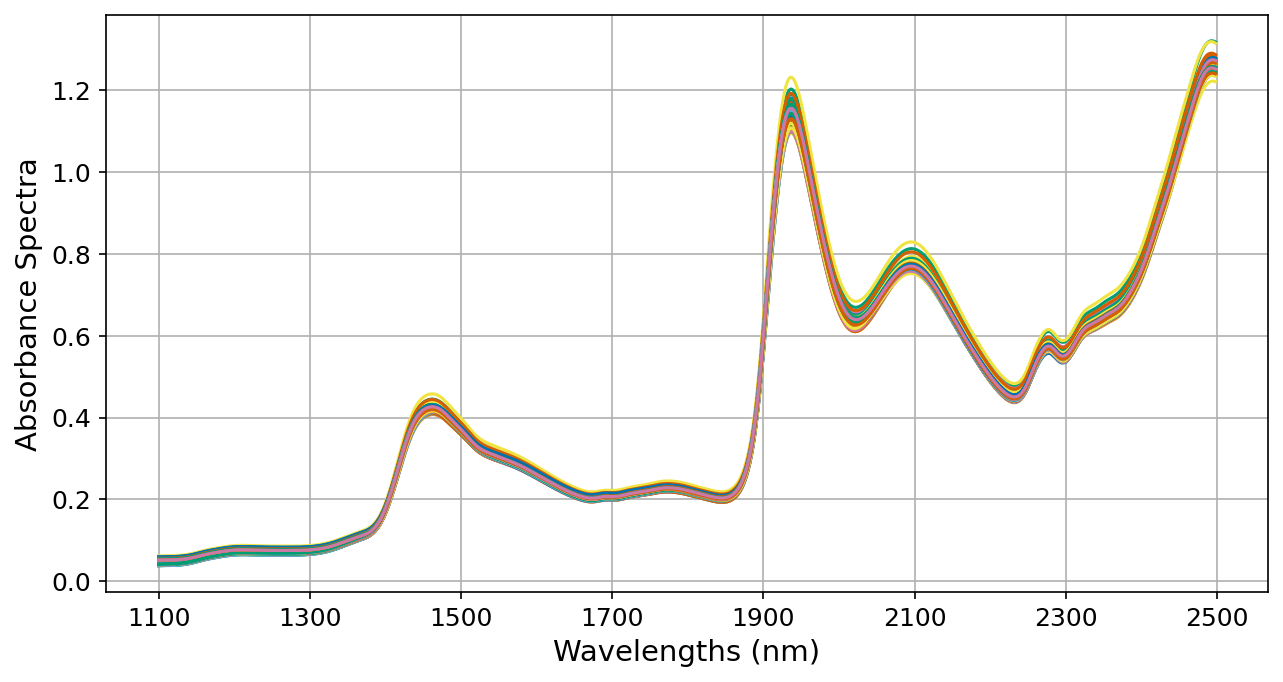

In [5]:
with plt.style.context(('seaborn-colorblind')):
    plt.figure(figsize=(10, 5), dpi=150)

    for i in range(honey_nirs.shape[0]):
        plt.plot(honey_nirs.columns[:-1], honey_nirs.iloc[i, :-1], lw=1.5)

    plt.xticks(ticks=[0, 100, 200, 300, 400, 500, 600, 700], 
            labels=["1100", "1300", "1500", "1700", "1900", "2100", "2300", "2500"],
            fontsize=12)

    plt.yticks(fontsize=12)

    plt.xlabel('Wavelengths (nm)', fontsize=14)
    plt.ylabel('Absorbance Spectra', fontsize=14)
    plt.grid(visible=True)
    plt.show()

### Correlation Matrix

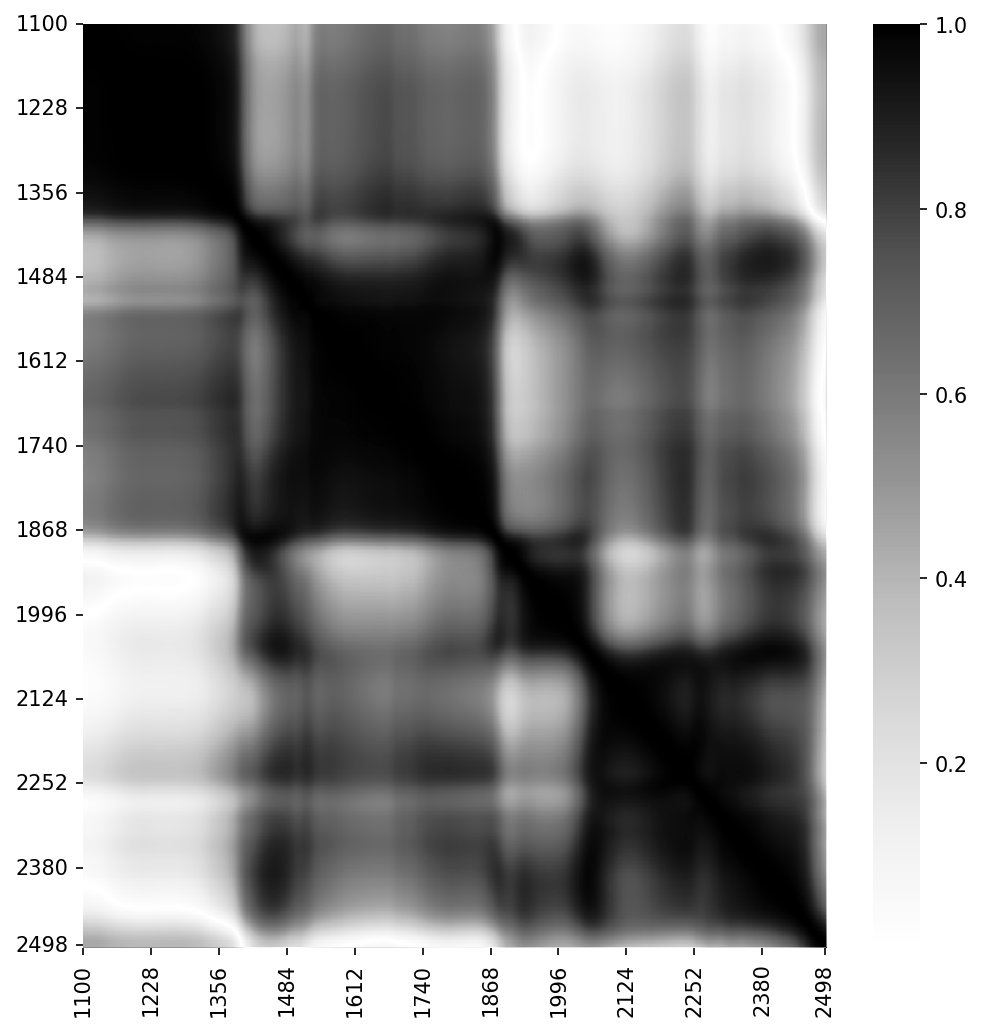

In [6]:
ticks = list(range(0, 701, 64)) + [699]
labels = [str(2*x+1100) for x in ticks]

plt.figure(figsize=(8, 8), dpi=150)

sns.heatmap(honey_nirs.corr().abs(), cmap="Greys")

plt.xticks(ticks, labels=labels, fontsize=10, rotation=90)
plt.yticks(ticks, labels=labels, fontsize=10, rotation=0)

plt.show()

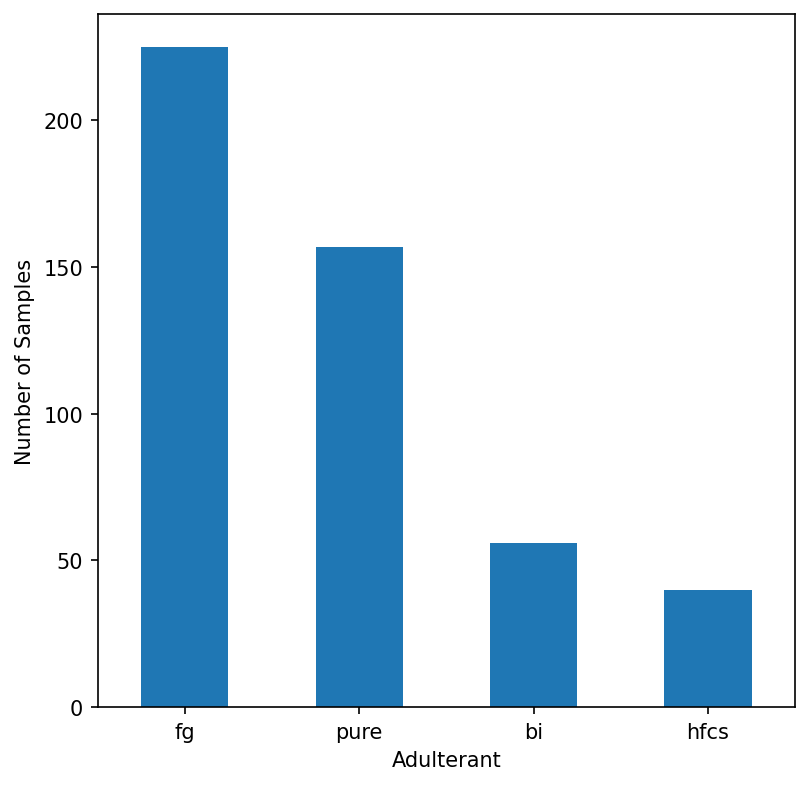

In [8]:
df = pd.read_csv("C:\\Users\\argan\\OneDrive\\Desktop\\DDP\\Data\\Honey Data\\honey_nirs.csv")

plt.figure(figsize=(6, 6), dpi=150)
df['label.full'].value_counts().plot(kind='bar')
plt.xlabel("Adulterant")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()

In [9]:
# Multiplicative Scatter Correction

def msc(input_data, reference=None):
    ''' Perform Multiplicative Scatter Correction'''
   
    # Mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
 
    return (data_msc, ref)

In [10]:
Xmsc = msc(honey_nirs.values[:, :-1])[0]

### Absorbance Spectra after MSC

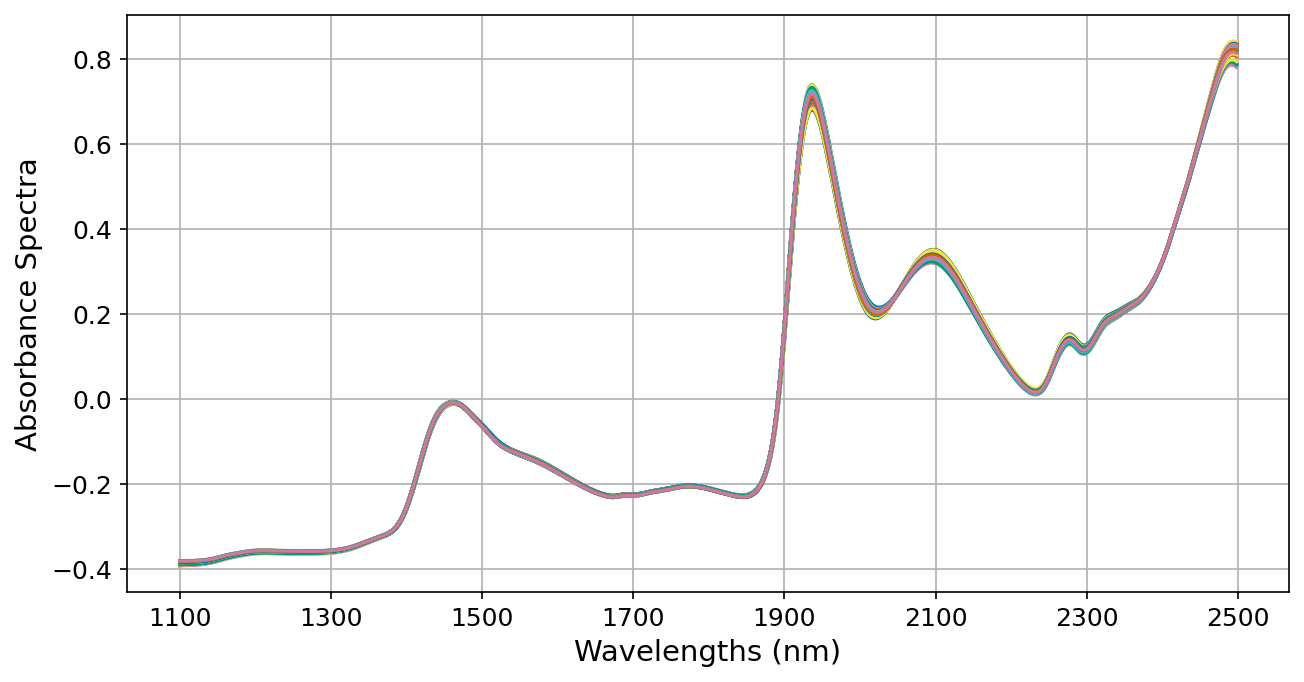

In [12]:
with plt.style.context(('seaborn-colorblind')):
    plt.figure(figsize=(10, 5), dpi=150)

    for i in range(honey_nirs.shape[0]):
        plt.plot(honey_nirs.columns[:-1], Xmsc[i, :], lw=1.5)

    plt.xticks(ticks=[0, 100, 200, 300, 400, 500, 600, 700], 
            labels=["1100", "1300", "1500", "1700", "1900", "2100", "2300", "2500"],
            fontsize=12)

    plt.yticks(fontsize=12)

    plt.xlabel('Wavelengths (nm)', fontsize=14)
    plt.ylabel('Absorbance Spectra', fontsize=14)
    plt.grid(visible=True)
    plt.show()

### Lower Resolution Spectra

In [13]:
X_0 = honey_nirs.iloc[:, :-1]
X_2 = honey_nirs.iloc[:, :-1:5]
X_4 = honey_nirs.iloc[:, :-1:10]
X_6 = honey_nirs.iloc[:, :-1:20]
X_8 = honey_nirs.iloc[:, :-1:40]
X_10 = honey_nirs.iloc[:, :-1:50]

X_list = [X_0, X_2, X_4, X_6, X_8, X_10]

y = honey_nirs.iloc[:, -1]

X_splits = []
for X in X_list:
    X_splits.append(train_test_split(X, y, 
                                     test_size=0.3, 
                                     stratify=y,
                                     shuffle=True, 
                                     random_state=SEED
                                    )
                   )

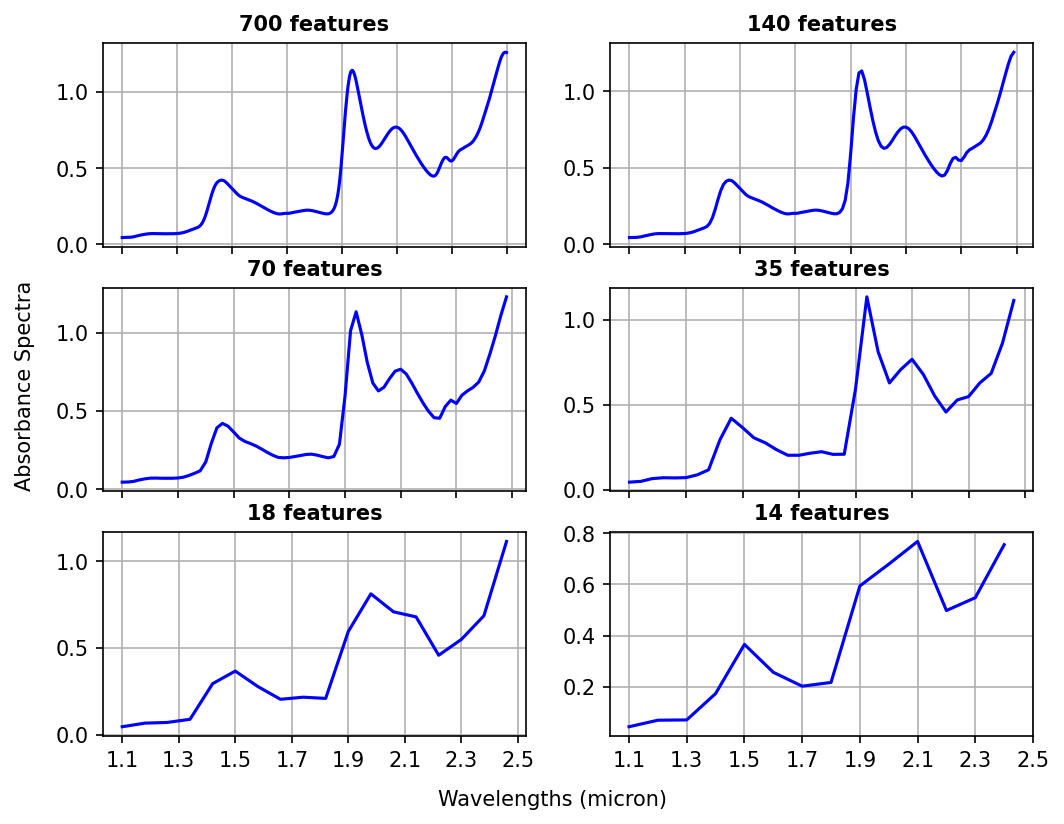

In [14]:
fig, axes = plt.subplots(3, 2, squeeze=False, figsize=(8, 6), dpi=150)

w_ticks = [1100, 1300, 1500, 1700, 1900, 2100, 2300, 2500]

axes[0][0].plot([int(w) for w in X_0.columns], X_0.iloc[10, :], lw=1.5, c='b')
axes[0][0].set_xticks(ticks=[1100, 1300, 1500, 1700, 1900, 2100, 2300, 2500], labels=[])
axes[0][0].set_title("{} features".format(X_0.shape[1]), fontsize=10, fontweight="bold")
axes[0][0].grid()

axes[0][1].plot([int(w) for w in X_2.columns], X_2.iloc[10, :], lw=1.5, c='b')
axes[0][1].set_xticks(ticks=[1100, 1300, 1500, 1700, 1900, 2100, 2300, 2500], labels=[])
axes[0][1].set_title("{} features".format(X_2.shape[1]), fontsize=10, fontweight="bold")
axes[0][1].grid()

axes[1][0].plot([int(w) for w in X_4.columns], X_4.iloc[10, :], lw=1.5, c='b')
axes[1][0].set_xticks(ticks=[1100, 1300, 1500, 1700, 1900, 2100, 2300, 2500], labels=[])
axes[1][0].set_title("{} features".format(X_4.shape[1]), fontsize=10, fontweight="bold")
axes[1][0].grid()

axes[1][1].plot([int(w) for w in X_6.columns], X_6.iloc[10, :], lw=1.5, c='b')
axes[1][1].set_xticks(ticks=[1100, 1300, 1500, 1700, 1900, 2100, 2300, 2500], labels=[])
axes[1][1].set_title("{} features".format(X_6.shape[1]), fontsize=10, fontweight="bold")
axes[1][1].grid()

axes[2][0].plot([int(w) for w in X_8.columns], X_8.iloc[10, :], lw=1.5, c='b')
axes[2][0].set_xticks(ticks=[1100, 1300, 1500, 1700, 1900, 2100, 2300, 2500])
axes[2][0].set_xticklabels([str(t/1000) for t in w_ticks], rotation=0)
axes[2][0].set_title("{} features".format(X_8.shape[1]), fontsize=10, fontweight="bold")
axes[2][0].grid()

axes[2][1].plot([int(w) for w in X_10.columns], X_10.iloc[10, :], lw=1.5, c='b')
axes[2][1].set_xticks(ticks=[1100, 1300, 1500, 1700, 1900, 2100, 2300, 2500])
axes[2][1].set_xticklabels([str(t/1000) for t in w_ticks], rotation=0)
axes[2][1].set_title("{} features".format(X_10.shape[1]), fontsize=10, fontweight="bold")
axes[2][1].grid()

fig.text(0.5, 0.04, 'Wavelengths (micron)', ha='center', va='center')
fig.text(0.06, 0.5, 'Absorbance Spectra', ha='center', va='center', rotation='vertical')

plt.show()

### Classification Performance

In [15]:
m = 0
y_pred_list = []
for X_train, X_test, y_train, y_test in X_splits:
    # Define PLS regression object.
    pls_binary = PLSRegression(n_components=min(20, X_train.shape[1]))

    # Fit and transform the data.
    X_pls = pls_binary.fit_transform(X_train, y_train)[0]

    y_pred_train = pls_binary.predict(X_train)
    y_pred_test = pls_binary.predict(X_test)

    scaler = MinMaxScaler()
    y_pred_train = scaler.fit_transform(y_pred_train)
    y_pred_test = scaler.fit_transform(y_pred_test)

    y_pred_list.append((y_pred_train, y_pred_test))

    y_labels_train = np.array(list(map(lambda x: 1 if x > 0.43 else 0, y_pred_train)))
    y_labels_test = np.array(list(map(lambda x: 1 if x > 0.43 else 0, y_pred_test)))

    y_labels_train = np.squeeze(y_labels_train)
    y_labels_test = np.squeeze(y_labels_test)

    acc_train = accuracy_score(y_train, y_labels_train)
    f1_train = f1_score(y_train, y_labels_train)

    acc_test = accuracy_score(y_test, y_labels_test)
    f1_test = f1_score(y_test, y_labels_test)

    print("Model {}".format(m))
    print("Train Accuracy Score:", np.round(acc_train, 4))
    print("Train F1 Score:", np.round(f1_train, 4))
    print()
    print("Test Accuracy Score:", np.round(acc_test, 4))
    print("Test F1 Score:", np.round(f1_test, 4))
    print("*"*50)
    print()

    m += 2

Model 0
Train Accuracy Score: 0.991
Train F1 Score: 0.9862

Test Accuracy Score: 0.9653
Test F1 Score: 0.9451
**************************************************

Model 2
Train Accuracy Score: 0.988
Train F1 Score: 0.9815

Test Accuracy Score: 0.9722
Test F1 Score: 0.9556
**************************************************

Model 4
Train Accuracy Score: 0.991
Train F1 Score: 0.9862

Test Accuracy Score: 0.9653
Test F1 Score: 0.9462
**************************************************

Model 6
Train Accuracy Score: 0.976
Train F1 Score: 0.9623

Test Accuracy Score: 0.9375
Test F1 Score: 0.9011
**************************************************

Model 8
Train Accuracy Score: 0.9731
Train F1 Score: 0.9577

Test Accuracy Score: 0.9653
Test F1 Score: 0.9462
**************************************************

Model 10
Train Accuracy Score: 0.9491
Train F1 Score: 0.9187

Test Accuracy Score: 0.9306
Test F1 Score: 0.898
**************************************************



Confusion Matrix - Test

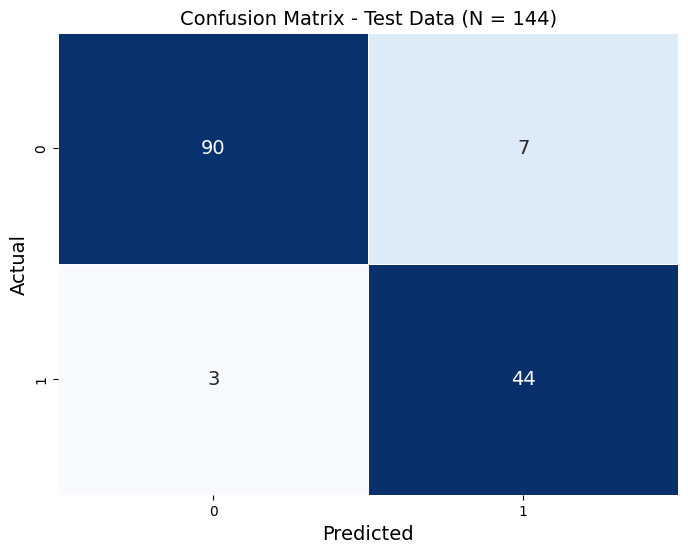

In [16]:
conf_mat = confusion_matrix(y_test, y_labels_test)
conf_mat_frac = conf_mat/conf_mat.sum(axis=1)

plt.figure(figsize=(8,6))

ax = sns.heatmap(conf_mat_frac, linewidth=0.5, cmap="Blues", annot=conf_mat, annot_kws={"size":14}, fmt='.0f', cbar=False)

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix - Test Data (N = {})'.format(y_test.shape[0]), fontsize=14)

plt.show()

Confusion Matrix - Train

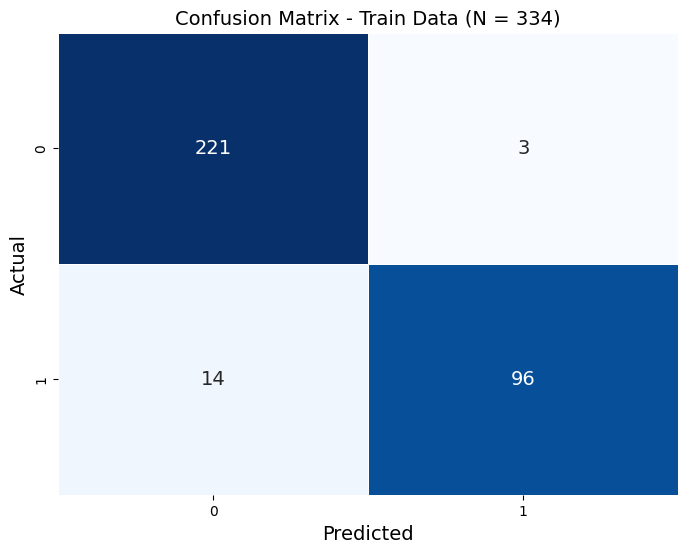

In [17]:
conf_mat = confusion_matrix(y_train, y_labels_train)
conf_mat_frac = conf_mat/conf_mat.sum(axis=1)

plt.figure(figsize=(8,6))

ax = sns.heatmap(conf_mat_frac, linewidth=0.5, cmap="Blues", annot=conf_mat, annot_kws={"size":14}, fmt='.0f', cbar=False)

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix - Train Data (N = {})'.format(y_train.shape[0]), fontsize=14)

plt.show()

ROC Curve

In [18]:
def roc_curve(y_pred, y_actual):
    scaler = MinMaxScaler()
    y_pred = scaler.fit_transform(y_pred)

    thres = np.linspace(0, 1, num=101, endpoint=True)

    cp = (y_actual == 1).sum()
    cn = (y_actual == 0).sum()

    tpr = []
    fpr = []

    for t in thres:
        y_labels = np.array(list(map(lambda x: 1 if x > t else 0, y_pred)))
        y_labels = np.squeeze(y_labels)

        tpr_i = ((y_labels == 1) & (y_actual == 1)).sum()/cp
        fpr_i = ((y_labels == 1) & (y_actual == 0)).sum()/cn

        tpr.append(tpr_i)
        fpr.append(fpr_i)

    return tpr, fpr

Test

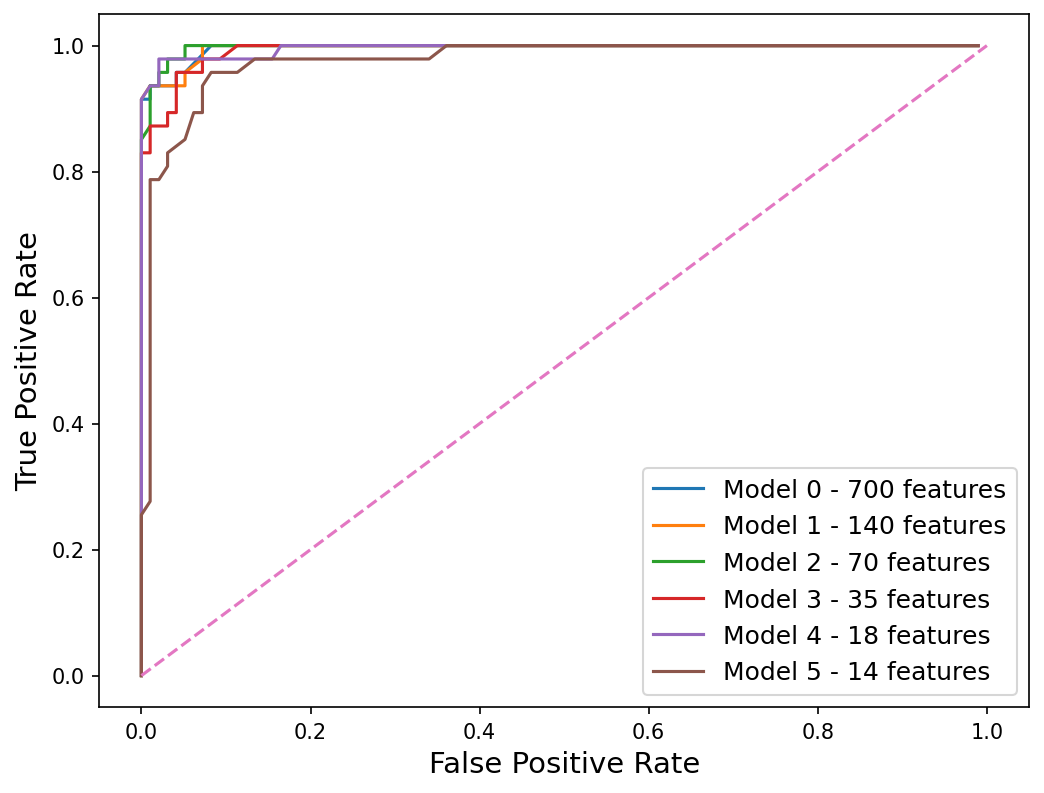

In [21]:
plt.figure(figsize=(8,6), dpi=150)

m = 0
for i, y in enumerate(y_pred_list):
    tpr_test, fpr_test = roc_curve(y[1], y_test)

    plt.plot(fpr_test, tpr_test, label="Model {} - {} features".format(m, X_list[i].shape[1]))

    m += 1

plt.plot([0, 1], ls="--")

plt.ylabel('True Positive Rate', fontsize=14)
# plt.xlim(-0.05, 0.3)
# plt.ylim(0.7, 1.05)
plt.legend(loc="lower right", fontsize=12)
plt.xlabel('False Positive Rate', fontsize=14)
plt.savefig("C:\\Users\\argan\\OneDrive\\Desktop\\Final Report\\roc_low_spectra.png")
plt.show()

Train

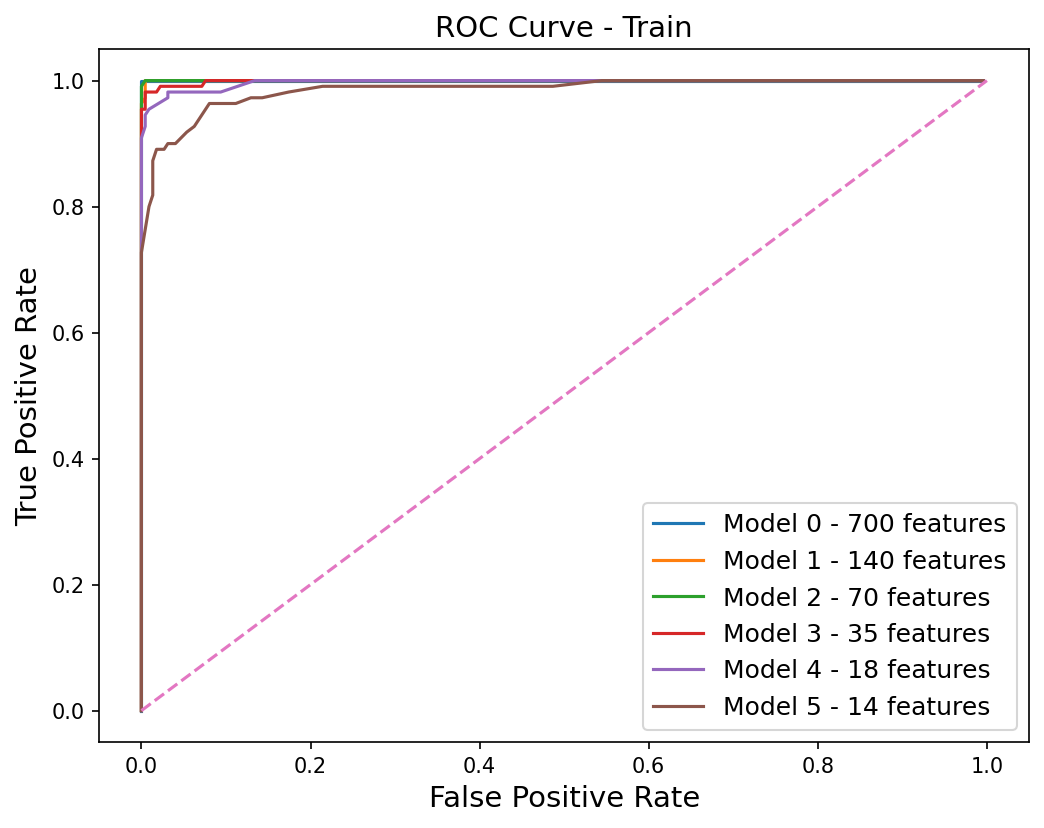

In [20]:
plt.figure(figsize=(8,6), dpi=150)

m = 0
for i, y in enumerate(y_pred_list):
    tpr_train, fpr_train = roc_curve(y[0], y_train)

    plt.plot(fpr_train, tpr_train, label="Model {} - {} features".format(m, X_list[i].shape[1]))

    m += 1

plt.plot([0, 1], ls="--")

plt.ylabel('True Positive Rate', fontsize=14)
# plt.xlim(-0.05, 0.3)
# plt.ylim(0.7, 1.05)
plt.legend(loc="lower right", fontsize=12)
plt.xlabel('False Positive Rate', fontsize=14)
plt.title('ROC Curve - Train', fontsize=14)
plt.show()